# Connect to Google Drive

In [0]:
#Step 1 part 1: connect to drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130942 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.4-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.4-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.4-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

# Train the model

In [0]:
import numpy as np
import pandas as pd
from random import sample
import pickle, cv2

from matplotlib.pyplot import imread
import matplotlib.pyplot as plt

import sklearn
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics

from keras import applications, optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras.utils import np_utils
from keras.models import model_from_json
from keras.models import load_model
from keras.utils import plot_model

import json

Using TensorFlow backend.


In [0]:
def train_validation_split(x, y):
    X_training, X_test, y_training, y_test = train_test_split(x, y, stratify=y, random_state=1337)
    X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, stratify=y_training, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
def one_hot(y_train, y_val, y_test, n_classes):
    y_train = np_utils.to_categorical(y_train, n_classes)
    y_val = np_utils.to_categorical(y_val, n_classes)
    y_test = np_utils.to_categorical(y_test, n_classes)

    return y_train, y_val, y_test

In [0]:
def build_fit_save_cnn(input_shape, n_classes, epochs, batch_size, X_train, X_val, y_train, y_val):
    base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    add_model.add(Dense(512, activation='relu'))
    add_model.add(Dense(512, activation='relu'))
    add_model.add(Dropout(0.25))
    add_model.add(Dense(n_classes, activation='softmax'))

    # combine base model and fully connected layers
    final_model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

    # specify SDG optimizer parameters
    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

    # compile model
    final_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    history = final_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val))

    score = final_model.evaluate(X_val, y_val, verbose=0)
    print('Val. score:', score[0])
    print('Val. accuracy:', score[1])
    
    plot_model(final_model, to_file='drive/ML-Kaggle/CNN-VGG19-Kaggle-Model.svg')
    show_history(history)
    save_model(final_model,history)

    return final_model

In [0]:
def test_predict_score(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    test_pred = model.predict(X_test)

    print('Test score:', score[0])
    print('Test accuracy:', score[1])

    return test_pred, score

In [0]:
def save_model(model,history):
    
    open('drive/ML-Kaggle/Saved_models/CNN-VGG19-Kaggle.json', 'w').close()
    open('drive/ML-Kaggle/Saved_models/CNN-VGG19-Kaggle-weights.h5', 'w').close()
    
    model_json = model.to_json()
    with open('drive/ML-Kaggle/Saved_models/CNN-VGG19-Kaggle.json', 'w') as json_file:
        json_file.write(model_json)

    model.save_weights('drive/ML-Kaggle/Saved_models/CNN-VGG19-Kaggle-weights.h5')
    print('Model saved to disk!')
    
    with open('drive/ML-Kaggle/Data/CNN-VGG19-Kaggle-History.json', 'w') as f:
        json.dump(history.history, f)
    print('History saved to disk!')

In [0]:
def show_history(history):
    print(history.history.keys())

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
#     classes = classes[unique_labels(y_true, y_pred)]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, title=title, 
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    return ax

W0622 11:17:18.616070 140499267073920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0622 11:17:18.648211 140499267073920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0622 11:17:18.657276 140499267073920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0622 11:17:18.696972 140499267073920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 1s 0us/step


W0622 11:17:20.186596 140499267073920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0622 11:17:20.187881 140499267073920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0622 11:17:23.689220 140499267073920 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0622 11:17:23.759561 140499267073920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:7

Train on 675 samples, validate on 225 samples
Epoch 1/10
675/675 [==============================] - 21s 31ms/step - loss: 1.0752 - acc: 0.4356 - val_loss: 0.9036 - val_acc: 0.5111
Epoch 2/10
675/675 [==============================] - 11s 17ms/step - loss: 0.8175 - acc: 0.5985 - val_loss: 0.8334 - val_acc: 0.5911
Epoch 3/10
675/675 [==============================] - 11s 17ms/step - loss: 0.7005 - acc: 0.6919 - val_loss: 0.8947 - val_acc: 0.5511
Epoch 4/10
675/675 [==============================] - 11s 17ms/step - loss: 0.5446 - acc: 0.7748 - val_loss: 0.7178 - val_acc: 0.6756
Epoch 5/10
675/675 [==============================] - 12s 17ms/step - loss: 0.3108 - acc: 0.8874 - val_loss: 0.9624 - val_acc: 0.6267
Epoch 6/10
675/675 [==============================] - 12s 17ms/step - loss: 0.3621 - acc: 0.8859 - val_loss: 0.8464 - val_acc: 0.6622
Epoch 7/10
675/675 [==============================] - 12s 17ms/step - loss: 0.3407 - acc: 0.8593 - val_loss: 0.8512 - val_acc: 0.6400
Epoch 8/10
675/6

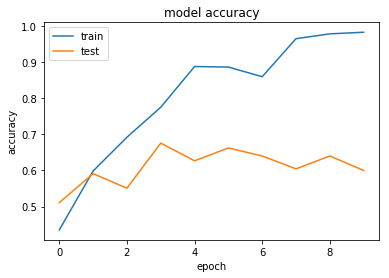

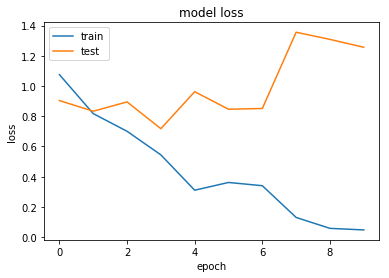

Model saved to disk!
History saved to disk!
Test score: 1.2937981875737508
Test accuracy: 0.6233333333333333


In [0]:
seed = 1337
np.random.seed(seed)

epochs = 10
batch_size = 25
input_shape = (224,224,3)

data = np.load('drive/ML-Kaggle/Data/images_labels_224.npz')
x = data['x']
y = data['y']
n_classes = len(np.unique(y))

X_train, X_val, X_test, y_train, y_val, y_test = train_validation_split(x, y)
y_train, y_val, y_test = one_hot(y_train, y_val, y_test, n_classes)
final_model = build_fit_save_cnn(input_shape, n_classes, epochs, batch_size, X_train, X_val, y_train, y_val)
test_pred, score = test_predict_score(final_model, X_test, y_test)

multiclass
multiclass
[1 0 1 2 1 1 0 1 0 2 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 2 2 2 0 1 1 1 2 1 1 2 0
 1 1 0 1 0 0 0 0 0 1 1 0 2 0 2 0 0 1 1 2 0 0 2 1 1 0 1 0 2 0 1 0 2 0 1 1 0
 0 0 2 1 0 0 1 1 0 1 0 2 0 0 0 0 0 1 0 0 1 2 0 0 0 0 2 2 0 0 1 2 0 1 1 0 1
 2 1 2 0 1 0 0 0 1 1 0 1 1 0 1 1 2 0 1 0 0 1 2 1 0 2 1 0 0 1 0 2 1 1 0 1 2
 1 2 1 0 0 0 1 2 1 0 0 1 1 1 1 2 0 0 0 2 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0
 0 0 1 2 0 1 2 0 1 0 0 0 2 1 1 0 0 2 0 1 1 2 1 0 0 2 2 0 0 2 1 0 2 0 0 1 1
 0 2 1 1 0 0 2 0 2 0 2 0 2 1 1 1 0 1 0 1 0 0 2 0 1 0 2 2 1 0 0 1 1 0 1 1 2
 1 1 0 1 2 1 1 0 1 1 1 0 2 0 1 0 1 2 1 0 1 0 1 1 1 0 0 2 0 2 1 0 1 0 0 0 2
 0 0 2 2] [1 1 1 2 1 2 0 1 0 0 1 1 1 2 0 1 1 2 1 0 0 1 0 2 2 2 0 2 2 1 1 1 0 1 2 0 0
 1 1 1 1 1 2 0 0 2 1 1 0 0 1 2 0 0 1 1 2 1 0 0 0 1 0 1 0 2 0 2 2 0 2 1 1 1
 1 2 2 0 0 0 1 0 0 1 2 2 2 0 0 0 1 1 0 0 0 2 2 1 2 0 2 2 0 2 1 2 0 2 1 0 1
 2 2 0 0 1 0 0 0 1 1 0 1 1 2 1 2 2 0 0 0 2 0 2 1 0 2 0 0 0 1 2 2 1 0 0 0 2
 2 1 1 0 2 0 2 0 1 1 0 1 1 2 2 2 0 0 0 0 2 1 1 0 2 1 2 1 1 1 1 0 0 1

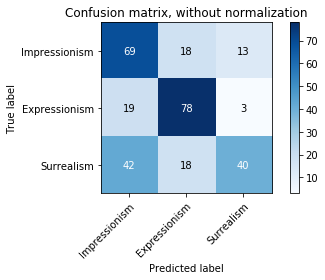

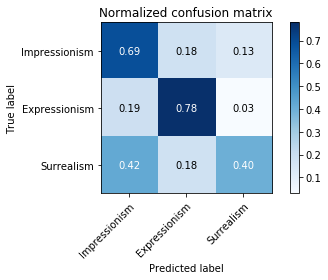

In [0]:
class_names = ["Impressionism", "Expressionism", "Surrealism"]

y_pred = np.argmax(test_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

print(type_of_target(y_pred))
print(type_of_target(y_test_))

print(y_pred,y_test_)
print(len(y_pred),len(y_test_))
    

plot_confusion_matrix(y_test_, y_pred, classes=class_names, title='Confusion matrix, without normalization')
plot_confusion_matrix(y_test_, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()

In [0]:
precision_recall_fscore_support(y_test_, y_pred, average='macro')

(0.6430884904569115, 0.6233333333333334, 0.6139308251457783, None)

# Predict

In [0]:
import numpy as np
from sys import argv
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from skimage.transform import resize
import pickle, cv2
from keras import optimizers
from keras.models import load_model
from keras.models import model_from_json

Using TensorFlow backend.


In [0]:
def load_model():
    json_file = open('drive/ML-Kaggle/Saved_models/CNN-VGG19-Kaggle.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('drive/ML-Kaggle/Saved_models/CNN-VGG19-Kaggle-weights.h5')

    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    loaded_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return loaded_model


In [0]:
def make_prediction(img_path):
    model = load_model()

    with open('drive/ML-Kaggle/Data/class_dict.pkl', 'rb') as f:
        class_dict = pickle.load(f)

    image = cv2.imread(img_path, 1)
    image = prepare_image(image)
    images = []
    images.append(image)
    images = np.array(images)
    image_size = 224
    n_channels = 3
    X_batch = images.reshape(1, image_size, image_size, n_channels)

    preds = model.predict(X_batch)

    top_3 = np.argpartition(preds[0], -3)[-3:]
    top_3 = reversed(top_3[np.argsort(preds[0][top_3])])
    print('Top 3 Predictions:')
    print('------------------')
    for i in top_3:
        print('{0}: {1:.2f}%'.format(class_dict[i], 100 * preds[0][i]))


In [0]:
def prepare_image(image, target_width=224, target_height=224, max_zoom=0.2):
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height

    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)

    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height

    image = image[y0:y1, x0:x1]
    image = cv2.resize(image, (target_width, target_height))

    return image.astype(np.float32) / 255

In [0]:
if __name__ == '__main__':
    img_path = "drive/ML-Kaggle/UnseenData/Surrealism/39150.jpg"
    make_prediction(img_path)

Top 3 Predictions:
------------------
Surrealism: 86.52%
Expressionism: 13.11%
Impressionism: 0.37%
